In [104]:
import tensorflow as tf
import json
import numpy as np
import pandas as pd

from google.cloud import bigquery
from google.cloud import storage

from google.cloud import aiplatform


import matplotlib.pyplot as plt
import seaborn as sns
#https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/custom/custom-tabular-bq-managed-dataset.ipynb

In [105]:
print(tf.__version__)

2.11.0


In [108]:
#table_id='new_incident'
table_id='test_incident'
# table_id='validation_incident'

projectId='smart-data-ml'
dataset_id='SMartML'
REGION="asia-southeast1"

if  table_id=='new_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name','imported_at']
 filePath='../../data/Bi_Prediction_New_Incident.csv'
elif table_id=='test_incident' or table_id=='validation_incident':
 unUsedColtoPredict=['severity','id','severity_id','severity_name']  
 filePath=f'../../data/Bi_Prediction_{table_id}.csv'
    
isLocalModel=True

isBQToCSV=False

PATH_FOLDER_ARTIFACTS="model_binary"  

modelFile_endPoint=1 
#1=local(dev)/gcs(clound function) and 2=vertext

localFile=True


In [111]:
from google.oauth2 import service_account
mycredentials = service_account.Credentials.from_service_account_file(r'C:\Windows\smart-data-ml-91b6f6204773.json')

if isBQToCSV:
    
    
    bqclient= bigquery.Client(project=projectId,credentials=mycredentials)
    def download_table(bq_table_uri: str):

        prefix = "bq://"
        if bq_table_uri.startswith(prefix):
            bq_table_uri = bq_table_uri[len(prefix) :]

        table = bigquery.TableReference.from_string(bq_table_uri)
        rows = bqclient.list_rows(table)
        return rows.to_dataframe()

    dfNewData=download_table(f"{projectId}.{dataset_id}.{table_id}")
    dfNewData.to_csv(filePath,index=False)    
    print(dfNewData.info())


# Load and Map Data Test

In [112]:
if  localFile:
    dfNewData=pd.read_csv(filePath)

# dfNewData=dfNewData.sample(3)

In [113]:
mapping_file="incident_sevirity_to_binary.json"

with open(mapping_file, 'r') as json_file:
 map_sevirity_to_class= json.load(json_file)
                                  
print(map_sevirity_to_class)


{'Normal': 0, 'Critical': 1}


In [114]:
if table_id=='new_incident':
    dfNewData.insert(2, 'severity', dfNewData['severity_name'].map(map_sevirity_to_class),True)
    print(dfNewData.info())
elif table_id=='test_incident' or table_id=='validation_incident':
    
    dfNewData=dfNewData.rename(columns={'label_binary_severity':'severity'})
    dfNewData=dfNewData.drop(columns=['label_multi_severity'])
    if 'id' not in dfNewData.columns.to_list():
        dfNewData=dfNewData.reset_index(drop=True)
        dfNewData = dfNewData.reset_index(level=0)
        dfNewData.rename(columns={"index": "id"},inplace=True)
        dfNewData['id']=dfNewData['id']+1
print(filePath)  

# dfNewData=dfNewData.sample(10)
print(dfNewData.info())
dfNewData.tail(10)


../../data/Bi_Prediction_test_incident.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         217 non-null    int64  
 1   severity_id                217 non-null    int64  
 2   severity_name              217 non-null    object 
 3   sla                        217 non-null    object 
 4   product_type               217 non-null    object 
 5   brand                      217 non-null    object 
 6   service_type               217 non-null    object 
 7   incident_type              217 non-null    object 
 8   open_to_close_hour         217 non-null    float64
 9   response_to_resolved_hour  217 non-null    float64
 10  severity                   217 non-null    int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 18.8+ KB
None


,id,severity_id,severity_name,sla,product_type,brand,service_type,incident_type,open_to_close_hour,response_to_resolved_hour,severity
207,208,4,Cosmatic,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,1001.616667,982.766667,0
208,209,4,Cosmatic,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,8.633333,8.000000,0
209,210,4,Cosmatic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Upgrade Software,7.000000,7.000000,0
210,211,4,Cosmatic,24x7 4Hrs Response Time,Software,VMWare,Request,General Incident,9.233333,8.000000,0
211,212,4,Cosmatic,24x7 4Hrs Resolution Time,Software,VMWare,Request,Software,364.683333,342.300000,0
212,213,2,Major,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,General Incident,1.000000,1.000000,1
213,214,3,Minor,24x7 4Hrs Resolution Time,Access Point,Cisco,Incident,General Incident,27.000000,24.033333,0
214,215,4,Cosmatic,24x7 4Hrs Resolution Time,Access Point,Cisco,Request,Configuration Change,0.500000,0.500000,0
215,216,2,Major,24x7 4Hrs Resolution Time,Tape Library,DELL,Incident,General Incident,1.133333,1.000000,1
216,217,4,Cosmatic,24x7 4Hrs Resolution Time,Tape Library,Oracle,Request,Report,2.000000,2.000000,0


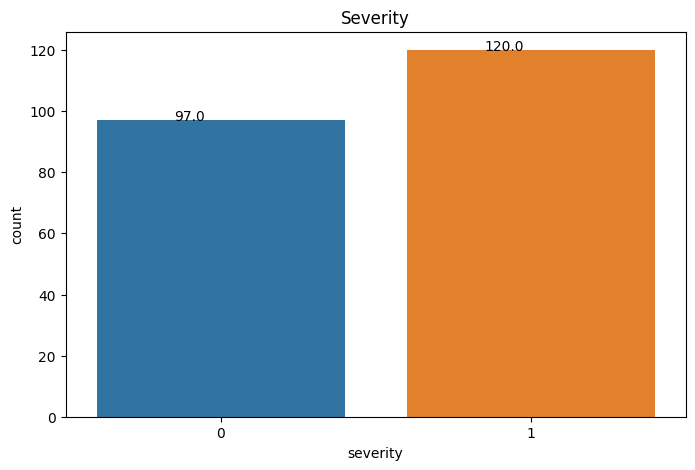

In [115]:
def plot_class(df):
    fig , ax = plt.subplots(figsize=(8,5))
    ax =sns.countplot(x='severity', data=df,)
    for p in ax.patches:
       ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))
    plt.title('Severity')
    plt.show()
    
plot_class(dfNewData)

# Load Model from Directory to Predict

In [116]:
model = tf.keras.models.load_model(PATH_FOLDER_ARTIFACTS)    
print(f"Load from {PATH_FOLDER_ARTIFACTS}")
# model.summary()

Load from model_binary


In [117]:
pdPrediction=pd.DataFrame(columns=['_id','_predict_severity'])

for  row_dict in dfNewData.to_dict(orient="records"):
      incident_id=row_dict['id']
      print(f"{incident_id} - {row_dict['severity']}") 
      for key_removed in unUsedColtoPredict:
       row_dict.pop(key_removed)
      # print(row_dict)  

      input_dict = {name: tf.convert_to_tensor([value]) for name, value in row_dict.items()}
      predictionResult = model.predict(input_dict)

      prob = tf.nn.sigmoid(predictionResult[0])
      prob_pct=(100 * prob)   
      _class= 1 if prob[0]>=0.5 else 0  
      print(f"{prob_pct[0]} % at {_class} as 0(Normal)/1(Critcal)") # np.argmax(prob, axis=0
      
      
      pdPrediction =pd.concat([pdPrediction,pd.DataFrame.from_dict([{'_id':incident_id, '_predict_severity':_class}])] )
      # print(input_dict)  
   
      print("======================================================================================")

dfPredictData=pd.merge(dfNewData,pdPrediction,how='inner',left_on='id',right_on='_id')
dfPredictData=dfPredictData.drop(columns=['_id'])
dfPredictData=dfPredictData[['id','_predict_severity','severity']]
dfPredictData

1 - 1
1/1 [==============================] - 0s 410ms/step
56.470211029052734 % at 1 as 0(Normal)/1(Critcal)
2 - 1
1/1 [==============================] - 0s 49ms/step
28.388917922973633 % at 0 as 0(Normal)/1(Critcal)
3 - 1
1/1 [==============================] - 0s 44ms/step
87.29737091064453 % at 1 as 0(Normal)/1(Critcal)
4 - 0
1/1 [==============================] - 0s 48ms/step
1.320754885673523 % at 0 as 0(Normal)/1(Critcal)
5 - 1
1/1 [==============================] - 0s 51ms/step
82.16854095458984 % at 1 as 0(Normal)/1(Critcal)
6 - 1
1/1 [==============================] - 0s 53ms/step
82.1832504272461 % at 1 as 0(Normal)/1(Critcal)
7 - 1
1/1 [==============================] - 0s 56ms/step
91.72810363769531 % at 1 as 0(Normal)/1(Critcal)
8 - 1
1/1 [==============================] - 0s 52ms/step
82.16104125976562 % at 1 as 0(Normal)/1(Critcal)
9 - 1
1/1 [==============================] - 0s 52ms/step
95.47569274902344 % at 1 as 0(Normal)/1(Critcal)
10 - 1
1/1 [=======================

,id,_predict_severity,severity
0,1,1,1
1,2,0,1
2,3,1,1
3,4,0,0
4,5,1,1
...,...,...,...
212,213,1,1
213,214,0,0
214,215,0,0
215,216,1,1


# Classification Rerport

In [119]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
import matplotlib.pyplot as plt

In [121]:
className=list(set().union(list(dfPredictData['severity'].unique()),list(dfPredictData['_predict_severity'].unique())))
actualClass=[  f'actual-{x}' for x in  className]
predictedlClass=[  f'predcited-{x}' for x in className]

y_true=list(dfPredictData['severity'])
y_pred=list(dfPredictData['_predict_severity'])
cnf_matrix = confusion_matrix(y_true,y_pred)
cnf_matrix

# #index=actual , column=prediction
cm_df = pd.DataFrame(cnf_matrix,
                     index = actualClass, 
                     columns = predictedlClass)
cm_df

,predcited-0,predcited-1
actual-0,77,20
actual-1,13,107


In [122]:
print(classification_report(y_true, y_pred, labels=className))

              precision    recall  f1-score   support

           0       0.86      0.79      0.82        97
           1       0.84      0.89      0.87       120

    accuracy                           0.85       217
   macro avg       0.85      0.84      0.84       217
weighted avg       0.85      0.85      0.85       217

